In [1]:
import os
import subprocess
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tqdm.auto import tqdm
from scipy.optimize import minimize
from scipy.interpolate import RegularGridInterpolator
import imageio.v3 as iio

In [2]:
SRC = '/Users/gimli/cvr/data/zavity/Cely_sken_3_110proc'

In [3]:
videos = [file for file in os.listdir(SRC) if file.endswith("MP4")]

In [4]:
videos

['GX010968.MP4', 'GX020968.MP4']

In [5]:
video_timing = []
for video in videos:
    # taken from palivo - list timing of the video
    _cmd = ["ffprobe",
        "-i", str(os.path.join(SRC, video)),
        "-show_frames",
        "-show_entries", "frame=pkt_dts_time",
        "-select_streams", "v:0",
        "-print_format", "flat"]
    video_info_file_path = os.path.join(SRC, video.replace(".MP4", "-video-info.txt"))
    if not os.path.isfile(video_info_file_path):    
        with open(video_info_file_path, 'w') as f:
            p1 = subprocess.call(_cmd, stdout=f)
    with open(video_info_file_path, "rt") as f:
        video_timing.append(f.readlines())

In [6]:
vidcap = cv2.VideoCapture(os.path.join(SRC, videos[0]))

In [46]:
# measurements from 01_oio-draft.ipynb
measures = {
    "light_on": np.array([   68,  2625,  4875,  7458,  9958, 12418, 14806]),
    "light_off": np.array([    7,  2207,  4767,  7019,  9597, 12100, 14559, 16943, 17462]),
    "shift_per_frame": 13.95,
    "pixels_per_360": 27141.75, 
    "pixels_per_s": 334.46820753812216,
    "s_per_360": 81.14896838709679, 
    "frames_per_360": 1946,
    "rows": [(68, 2207),
             (2625, 4767),
             (4875, 7019),
             (7458, 9597),
             (9958, 12100),
             (12418, 14559),
             (14806, 16943)],
    "frame_size": (2160, 3840),
    "left_right_shift": 100
}

In [92]:
mio_height = measures["frame_size"][0] # frame height
mio_width = np.floor(measures["frames_per_360"] * measures["shift_per_frame"]).astype(int) # 13.95 from each frame
mio_depth = int(measures["frame_size"][1] // measures["shift_per_frame"])

row_mio = np.zeros((mio_height, mio_width, mio_depth), dtype=np.float16) # depth

# in the row area select frames in the middle of the interval
mn, mx = measures["rows"][0]
start = mn + (mx - mn) // 2 - measures["frames_per_360"] // 2 
end = start + measures["frames_per_360"]    
vidcap.set(cv2.CAP_PROP_POS_FRAMES, start)

for frameNo in tqdm(range(0, end - start), total=end - start, desc="processing frames"):
    success, frame = vidcap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype(np.float16)
    frame = np.fliplr(frame)
    frame = np.abs(np.diff(frame.astype(np.float16), axis=0, append=frame[:1, :])) + np.abs(np.diff(frame.astype(np.float16), axis=1, append=frame[:, :1]))
    for d in range(0, int(frame.shape[1] / measures["shift_per_frame"])): # solve each level separately
        h_shift = np.round(d / int(frame.shape[1] / measures["shift_per_frame"]) * measures["left_right_shift"]).astype(int)
        
        partial_first = 1 - (((frameNo + d) * measures["shift_per_frame"]) % 1)
        partial_last = ((frameNo + d + 1) * measures["shift_per_frame"]) % 1
                    
        w_start = (measures["shift_per_frame"] * (d + frameNo)) % mio_width
        w_end = (measures["shift_per_frame"] * (d + frameNo + 1)) % mio_width
        
        # first pixel (partial)                          
        if np.floor(w_start) != w_start:
            if h_shift:
                row_mio[h_shift:, np.floor(w_start).astype(int), d] += (frame[:-h_shift, np.floor(measures["shift_per_frame"] * d).astype(int)] * partial_first).astype(np.float16)
            else:
                row_mio[:, np.floor(w_start).astype(int), d] += (frame[:, np.floor(measures["shift_per_frame"] * d).astype(int)] * partial_first).astype(np.float16)
            
        # whole pixels
        if np.ceil(w_start) < np.floor(w_end): # easy case
            if h_shift:
                row_mio[h_shift:,
                    np.ceil(w_start).astype(int): np.floor(w_end).astype(int), 
                    d] += frame[:-h_shift, np.ceil(measures["shift_per_frame"] * d).astype(int): np.floor(measures["shift_per_frame"] * (d + 1)).astype(int)]
            else:
                row_mio[:,
                    np.ceil(w_start).astype(int): np.floor(w_end).astype(int), 
                    d] += frame[:, np.ceil(measures["shift_per_frame"] * d).astype(int): np.floor(measures["shift_per_frame"] * (d + 1)).astype(int)]
        else: # mio_width overflow  
            slice_width = mio_width - np.ceil(w_start).astype(int)
            if h_shift:
                row_mio[h_shift:,
                    np.ceil(w_start).astype(int): mio_width, 
                    d] += frame[:-h_shift, np.ceil(measures["shift_per_frame"] * d).astype(int): np.ceil(measures["shift_per_frame"] * d).astype(int) + slice_width]            
                row_mio[h_shift:,
                    0: np.floor(w_end).astype(int), 
                    d] += frame[:-h_shift, np.ceil(measures["shift_per_frame"] * d).astype(int) + slice_width: np.floor(measures["shift_per_frame"] * (d + 1)).astype(int)]
            else:
                row_mio[:,
                    np.ceil(w_start).astype(int): mio_width, 
                    d] += frame[:, np.ceil(measures["shift_per_frame"] * d).astype(int): np.ceil(measures["shift_per_frame"] * d).astype(int) + slice_width]            
                row_mio[:,
                    0: np.floor(w_end).astype(int), 
                    d] += frame[:, np.ceil(measures["shift_per_frame"] * d).astype(int) + slice_width: np.floor(measures["shift_per_frame"] * (d + 1)).astype(int)]
            
        # last pixel (partial)
        if np.floor(w_end) != w_end:
            if h_shift:
                row_mio[h_shift:, np.floor(w_end).astype(int), d] += (frame[:-h_shift, np.floor(measures["shift_per_frame"] * (d + 1)).astype(int)] * partial_last).astype(np.float16)
            else:
                row_mio[:, np.floor(w_end).astype(int), d] += (frame[:, np.floor(measures["shift_per_frame"] * (d + 1)).astype(int)] * partial_last).astype(np.float16)
        

processing frames:   0%|          | 0/1946 [00:00<?, ?it/s]

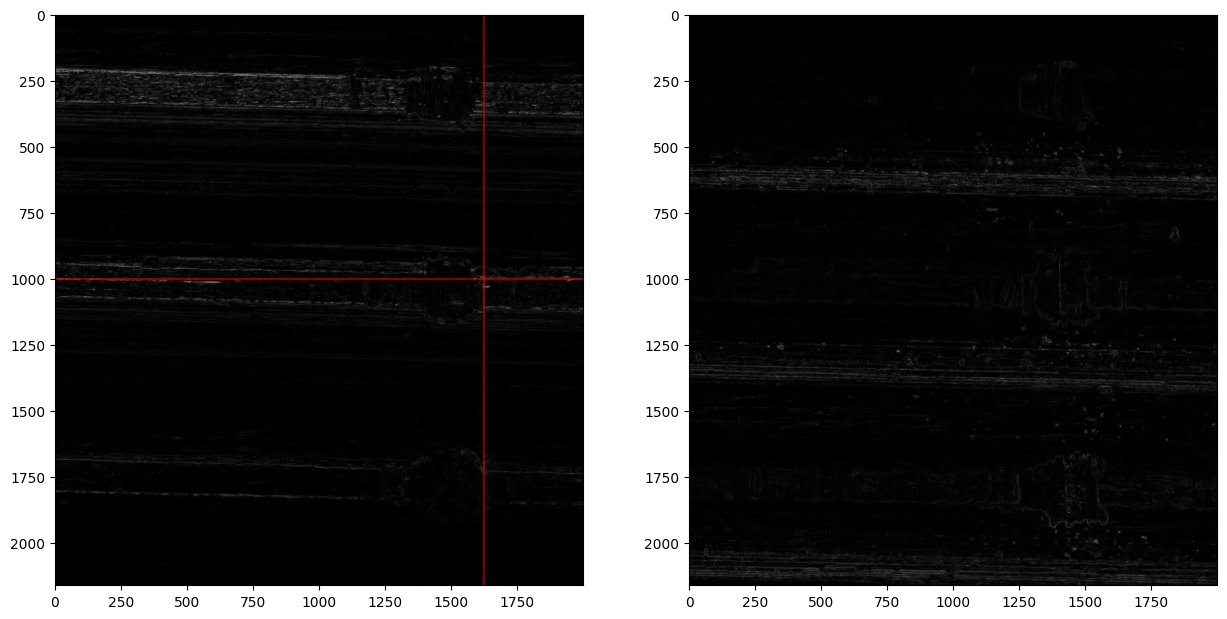

In [97]:
plt.figure(figsize=(15,10))
ax = plt.subplot(121)
ax.imshow(row_mio[:,:2000, 100].astype(np.float16), cmap="gray")
ax.axhline(1000, color="red", alpha=.5)
ax.axvline(1625, color="red", alpha=.5)
ax = plt.subplot(122)
ax.imshow(row_mio[:,:2000, -1].astype(np.float16), cmap="gray")
plt.show()

In [30]:
for d in tqdm(np.arange(row_mio.shape[2])):
    iio.imwrite(f"/Users/gimli/temp/zavit-mio/{d:03d}.png", row_mio[:,:, d])

  0%|          | 0/275 [00:00<?, ?it/s]

KeyboardInterrupt: 

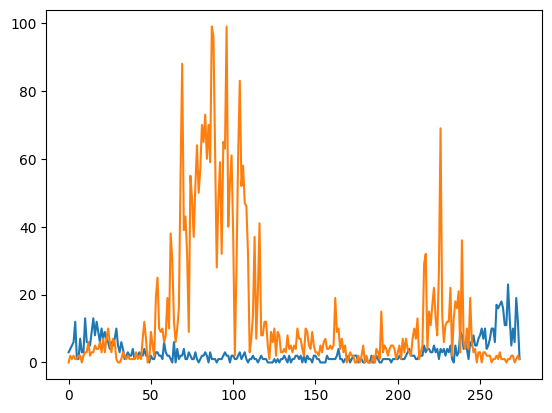

In [98]:
plt.plot(row_mio[1350, 250, :])
plt.plot(row_mio[1000, 1625, :])
plt.show()

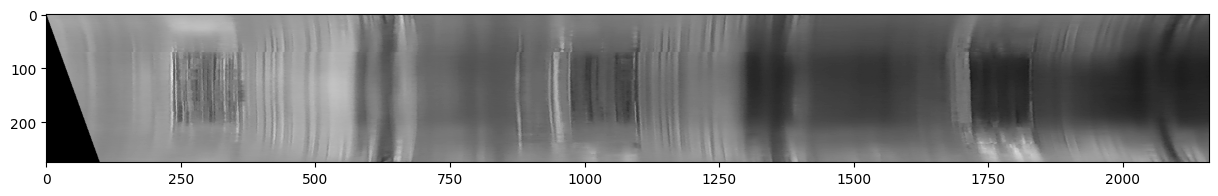

In [74]:
plt.figure(figsize=(15,3))
plt.imshow(row_mio[:, 1000, :].T, cmap="gray")
plt.show()

In [66]:
row_mio.shape

(2160, 27146, 275)

In [106]:
depth_map = (np.abs(275/2 - np.nanargmax(row_mio[:,:2000], axis=2)) / 275 * 2 * 255).astype(np.uint8)

In [107]:
iio.imwrite("/Users/gimli/Desktop/depth-map.png", depth_map)

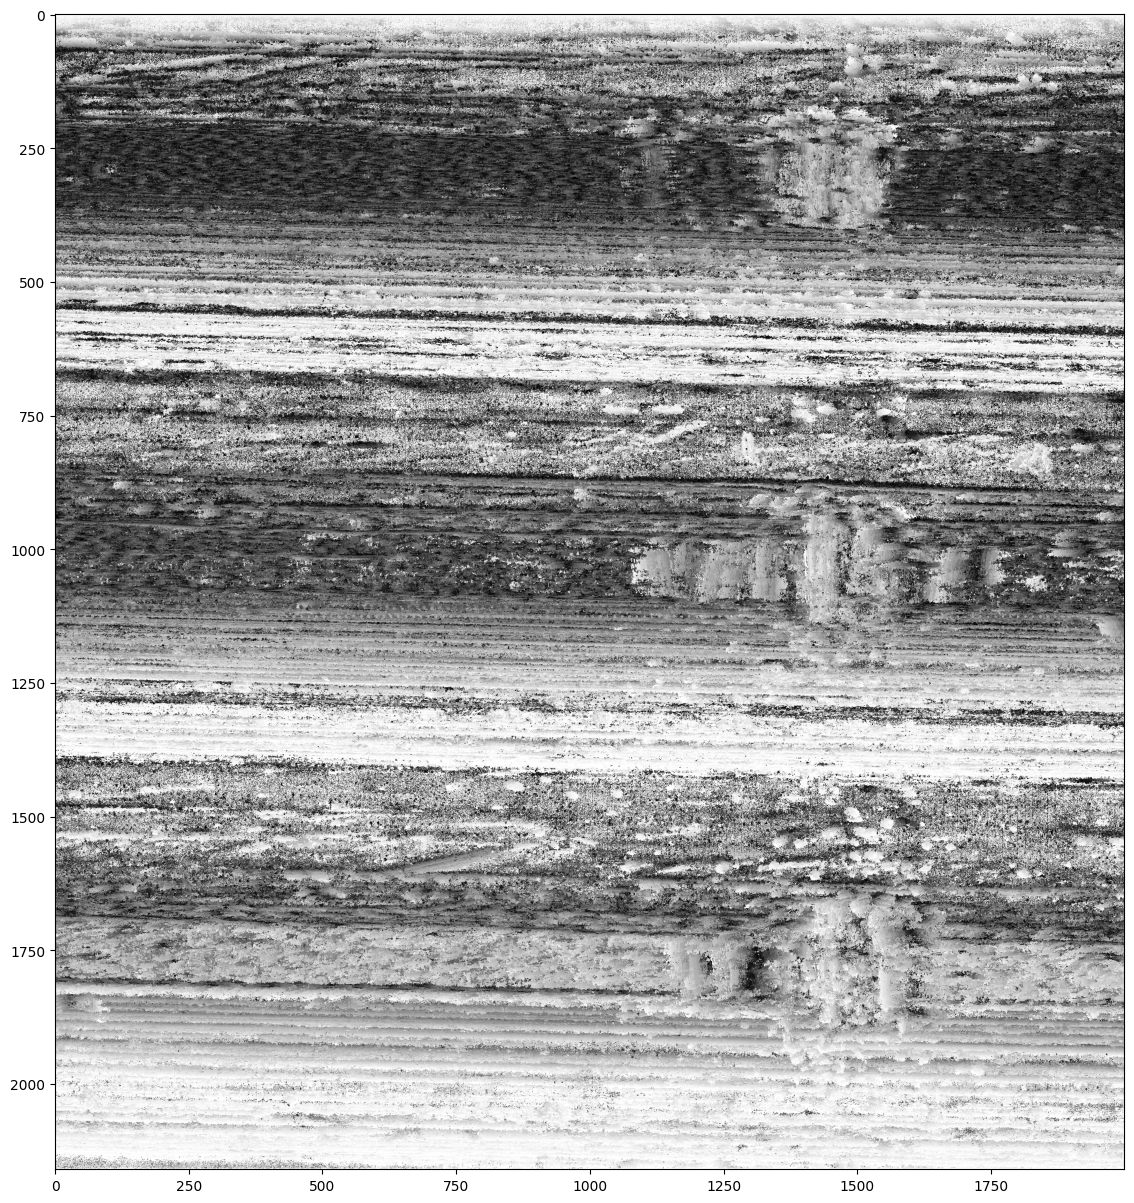

In [108]:
plt.figure(figsize=(15,15))
ax = plt.subplot(111)
ax.imshow(depth_map, cmap="gray")
plt.show()

In [111]:
from scipy.ndimage import gaussian_filter1d

In [113]:
blurred = gaussian_filter1d(row_mio[:,:2000].astype(float), sigma=10, axis=2)

In [182]:
(227 + np.argmax(blurred[1000,1625,:])) / 2

157.5

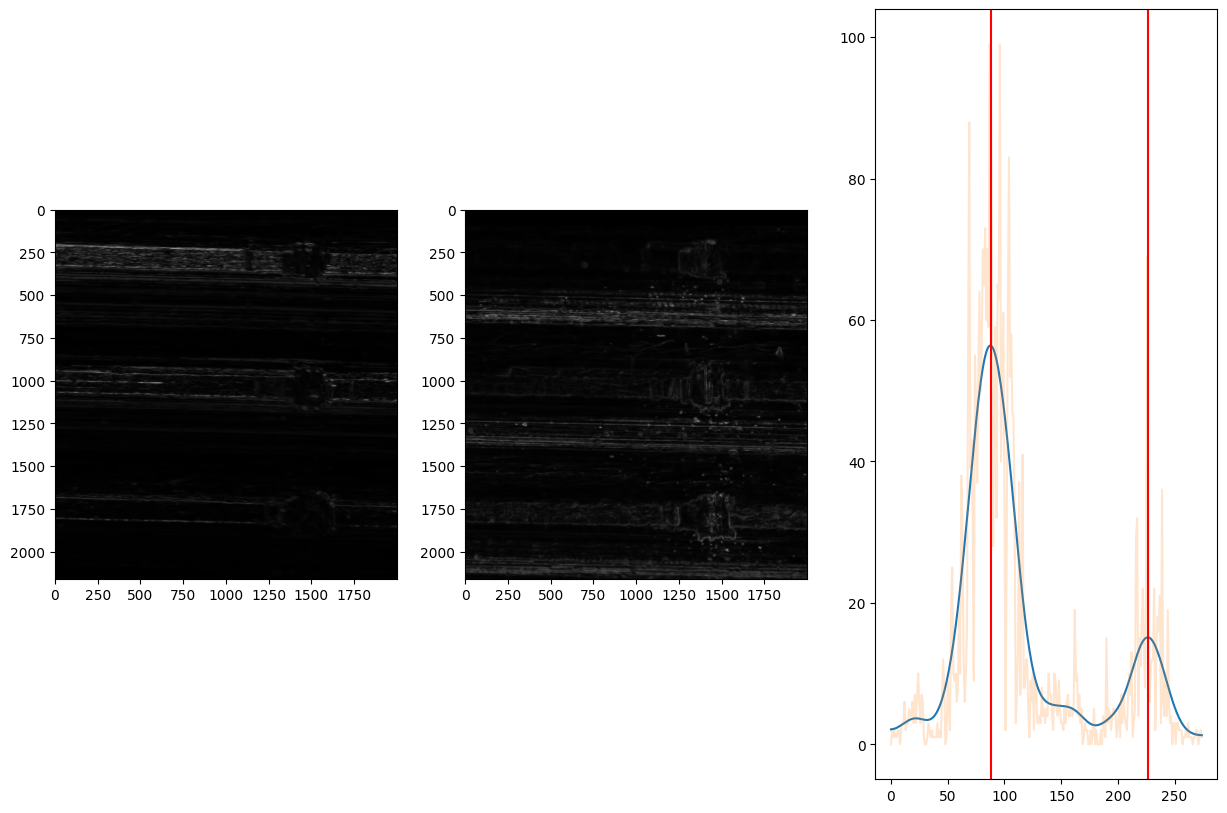

In [181]:
plt.figure(figsize=(15,10))
ax = plt.subplot(131)
ax.imshow(blurred[:, :, 100], cmap="gray")
ax = plt.subplot(132)
ax.imshow(blurred[:,:, -1], cmap="gray")
ax = plt.subplot(133)
ax.plot(blurred[1000,1625,:])
ax.plot(row_mio[1000,1625,:], alpha=0.2)
ax.axvline(np.argmax(blurred[1000,1625,:]), color="red")
ax.axvline(227, color="red")
plt.show()

In [183]:
depth_map = np.abs(157.5 - np.nanargmax(blurred, axis=2))

In [184]:
rot_matrix=cv2.getRotationMatrix2D((depth_map.shape[0] / 2, depth_map.shape[1] / 2), 1.2, 1)
rotated = cv2.warpAffine(depth_map, rot_matrix, (depth_map.shape[1], depth_map.shape[0]))
shape = gaussian_filter1d(np.mean(rotated, axis=1), sigma=85)
relative_depth = np.array([rotated[row] - shape[row] for row in np.arange(rotated.shape[0])])

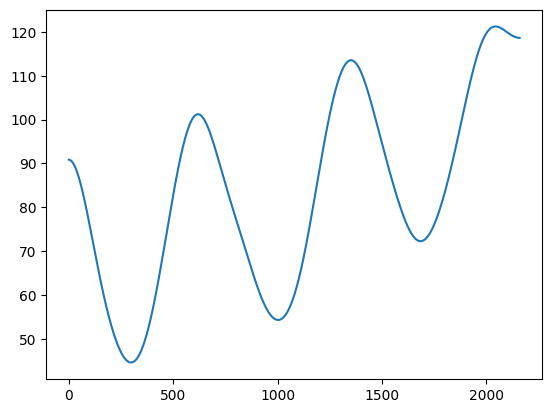

In [192]:
%matplotlib inline
plt.figure()
plt.plot(shape)
plt.show()

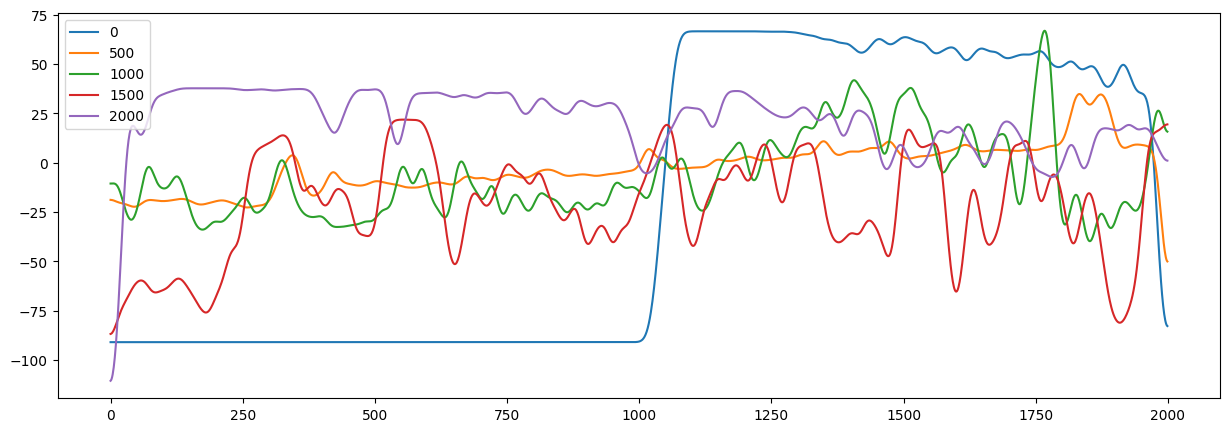

In [188]:
%matplotlib inline
plt.figure(figsize=(15,5))
for i in np.arange(0, rotated.shape[0], 500):
    plt.plot(gaussian_filter1d(rotated[i] - shape[i], sigma=11), label=f"{i}")
plt.legend()
plt.show()

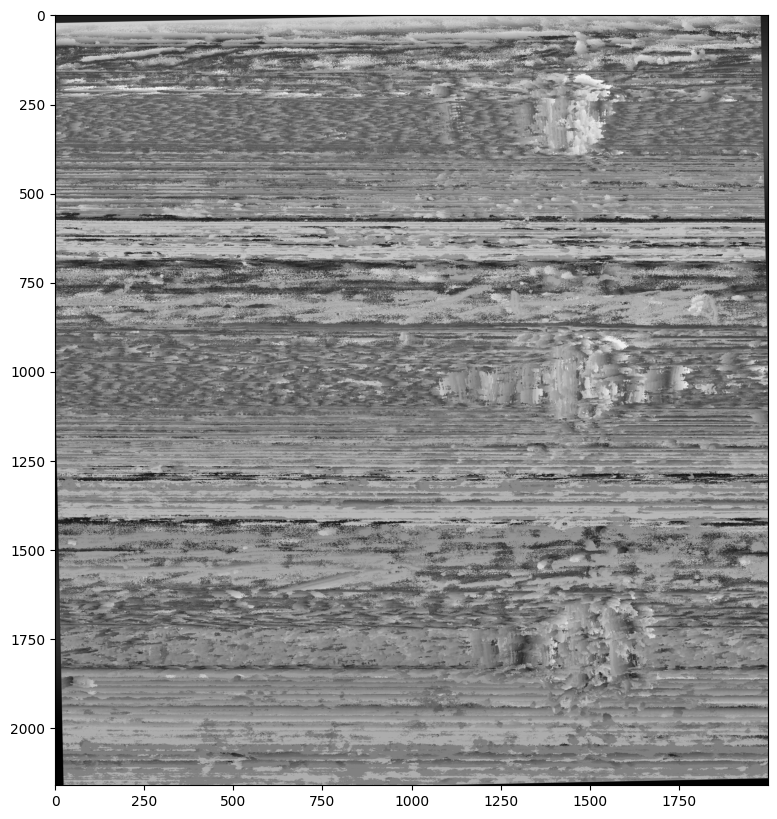

In [189]:
plt.figure(figsize=(15,10))
plt.imshow(relative_depth, cmap="gray")
plt.show()

In [148]:
from mpl_toolkits import mplot3d

In [190]:
%matplotlib notebook
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')

x, y = np.meshgrid(np.arange(relative_depth.shape[1]), np.arange(relative_depth.shape[0]))
# Creating plot
ax.plot_surface(x, y, relative_depth)
 
# show plot
plt.show()

<IPython.core.display.Javascript object>